# Problem 2 - Trying different penalty values

This experiment is related with experiments from 19-1-24. For the second knapsack instance, we will try different penalty values, and solve this instance with the lowest cost parameter combination.

### Problem instance

{'problem_type': 'knapsack', 'values': [2, 3, 4, 1, 1], 'weights': [1, 1, 4, 3, 2], 'weight_capacity': 9, 'penalty': $<variable>$, 'n_items': 5}
items': 5}


The original problem instances was tested with $penalty = 8$.

### QAOA lowest cost parameters

3-standard-rand-x-Powell

## Experiment

{'problem_type': 'knapsack', 'values': [2, 3, 4, 1, 1], 'weights': [1, 1, 4, 3, 2], 'weight_capacity': 9, 'penalty': 1, 'n_items': 5}
{'problem_type': 'knapsack', 'values': [2, 3, 4, 1, 1], 'weights': [1, 1, 4, 3, 2], 'weight_capacity': 9, 'penalty': 3, 'n_items': 5}
{'problem_type': 'knapsack', 'values': [2, 3, 4, 1, 1], 'weights': [1, 1, 4, 3, 2], 'weight_capacity': 9, 'penalty': 6, 'n_items': 5}
{'problem_type': 'knapsack', 'values': [2, 3, 4, 1, 1], 'weights': [1, 1, 4, 3, 2], 'weight_capacity': 9, 'penalty': 8, 'n_items': 5}
{'problem_type': 'knapsack', 'values': [2, 3, 4, 1, 1], 'weights': [1, 1, 4, 3, 2], 'weight_capacity': 9, 'penalty': 10, 'n_items': 5}
{'problem_type': 'knapsack', 'values': [2, 3, 4, 1, 1], 'weights': [1, 1, 4, 3, 2], 'weight_capacity': 9, 'penalty': 20, 'n_items': 5}


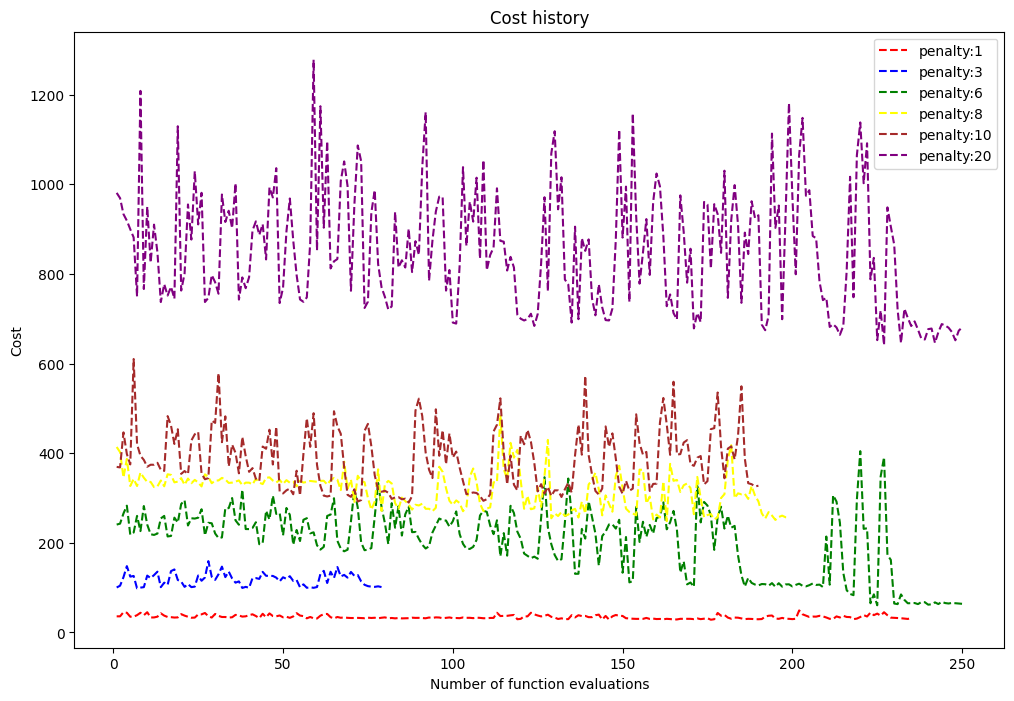

In [2]:
from tqdm import tqdm
from openqaoa.backends import create_device
from openqaoa import QAOA
from openqaoa.utilities import ground_state_hamiltonian
import matplotlib.pyplot as plt
import json
from openqaoa.problems import Knapsack


penalties = [1,3,6,8,10,20]
opt_results = []
colors = ['red','blue','green','yellow','brown','purple']

for penalty in penalties:
    knapsack_prob = Knapsack(values=[2,3,4,1,1],weights=[1,1,4,3,2],weight_capacity=9,penalty=penalty)
    print(knapsack_prob.problem_instance)
    knapsack_qubo = knapsack_prob.qubo
    knapsack_hamiltonian = knapsack_qubo.hamiltonian

    qiskit_device = create_device(location='ibmq', name='ibmq_qasm_simulator')
    q1 = QAOA()
    q1.set_device(qiskit_device)
    q1.set_circuit_properties(p=3, param_type='standard', init_type='rand', mixer_hamiltonian='x')
    q1.set_backend_properties(n_shots=5000, seed_simulator=1)
    q1.set_classical_optimizer(method='Powell', maxfev=250,maxiter=200, tol=0.01,
    optimization_progress=True, cost_progress=True, parameter_log=True)
    q1.compile(knapsack_qubo)
    q1.optimize()
    opt_results1 = q1.result
    opt_results.append(opt_results1)
    
    #export jsons
    with open('prob2_3-standard-rand-x-Powell_penalty=%s.json'% (str(penalty)), 'w') as archivo:
        json.dump(opt_results1.asdict(), archivo)

fig, ax = plt.subplots(figsize=(12,8))
for i in range(len(opt_results)):
    opt_results[i].plot_cost(color=colors[i],label='penalty:'+str(penalties[i]),ax=ax)
       
plt.savefig('prob1_3-standard-rand-x-Powell_differentPenalties.png', bbox_inches='tight')

## Analyzing the results

In [3]:
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(knapsack_hamiltonian)
print(f"The solutions found with brute force are {configuration} with an energy of {energy}")

The solutions found with brute force are ['000011110', '100011101'] with an energy of -10.0


In [5]:
import json
from openqaoa.algorithms import QAOAResult
from openqaoa.qaoa_components import Hamiltonian

results = []
for penalty in penalties:
    with open('prob2_3-standard-rand-x-Powell_penalty=%s.json'%str(penalty), 'r') as file:
        data = json.load(file)
    cost_hamiltonian = data['cost_hamiltonian']
    cost_hamiltonian = Hamiltonian.classical_hamiltonian(knapsack_qubo.terms,cost_hamiltonian['coeffs'],cost_hamiltonian['constant'])

    result = QAOAResult.from_dict(data,cost_hamiltonian)
    results.append(result)

    #result.plot_cost(figsize=(8,4),label='penalty=%s'%str(penalty))

In [6]:
print(f"The solutions found with brute force are {configuration} with an energy of {energy}")
print()

pen_index = 0
for result in results:
    print('Penalty:',penalties[pen_index])
    most_probable_states = ''
    for i in result.most_probable_states['solutions_bitstrings']:
        most_probable_states += i + ','
    most_probable_states = most_probable_states[:-1]
    print('The most probable state/s are',most_probable_states,'with an energy of',result.most_probable_states['bitstring_energy'])
    print()

    lowest_cost_bitstrings = result.lowest_cost_bitstrings(2)
    pen_index= pen_index+1

The solutions found with brute force are ['000011110', '100011101'] with an energy of -10.0

Penalty: 1
The most probable state/s are 110011111 with an energy of 14.0

Penalty: 3
The most probable state/s are 001110110 with an energy of 356.0

Penalty: 6
The most probable state/s are 011010010 with an energy of 3.0

Penalty: 8
The most probable state/s are 110010100 with an energy of 2.0

Penalty: 10
The most probable state/s are 001010011 with an energy of 6.0

Penalty: 20
The most probable state/s are 110000111 with an energy of 174.0



## Conclussions

First of all, is important to notice a fast stop on the optimization in $penalty=3$. Probably, this is the cause of  beeing the optimization with the highest bitstring energy for its most probable state.

The lowest bitstring energy for the most probable state was getted by $penalty=8$, $penalty=6$ and $penalty=10$ (in the mentioned order).